In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc as pm
import os
import sys
from torch.utils.data import DataLoader

sys.path.append(os.path.abspath('../src'))
from data_tools.data_utils import ReportingDataset, create_data_split

In [2]:
project_dir = project_dir = Path.cwd().parent
trunc_D = 40


create_data_split(
    start_year=2013,
    end_year=2020,
    D=trunc_D,
    data_folder_path = project_dir / "data",
    input_filename="DENGSP.csv",
    train_prop=0.7,
    val_prop=0.2,
    test_prop=0.1
)
complete_df = pd.read_csv(project_dir / "data" / "model" / "complete_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_utils.py:19: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf_raw = pd.read_csv(input_data_path, index_col=0)


In [3]:
y_true = complete_df.sum(axis=1)
y_true.index = pd.to_datetime(y_true.index)
y_true

Date_Symptoms
2013-02-09    1253
2013-02-10    1394
2013-02-11    1421
2013-02-12    1497
2013-02-13    1666
              ... 
2020-11-18     218
2020-11-19     211
2020-11-20     297
2020-11-21     223
2020-11-22     275
Length: 2844, dtype: int64

In [4]:
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)
val_df = pd.read_csv(project_dir / "data" / "model" / "validation_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

In [10]:
def mask_matrix(matrix, D):
        masked_matrix = matrix.copy()
        nrow, ncol = masked_matrix.shape

        for i in range(nrow):
            for j in range(ncol):
                if i + j > D - 1:
                     masked_matrix[i, j] = False
        return  masked_matrix

model_D = 40
mask = np.ones(shape=(model_D, model_D), dtype=bool)
mask = mask_matrix(mask, model_D)

reporting_triangle = np.zeros(shape=(len(train_df)-model_D, model_D, model_D))
for t in range(model_D, len(train_df)):
    #  reporting_triangles[t, :, :] = train_df[t-model_D:t, :model_D]

    matrix = train_df.copy().iloc[t-model_D:t, :model_D]
    matrix[~mask] = 0
    reporting_triangle[t-model_D, :, :] = matrix
 
reporting_triangle = reporting_triangle / reporting_triangle.max()
print(reporting_triangle.shape)
print(reporting_triangle[-1, :, :])



(1990, 40, 40)
[[0.00275482 0.00344353 0.00619835 ... 0.         0.         0.        ]
 [0.00206612 0.00585399 0.00482094 ... 0.         0.         0.        ]
 [0.00344353 0.00585399 0.00413223 ... 0.         0.         0.        ]
 ...
 [0.00309917 0.00792011 0.00585399 ... 0.         0.         0.        ]
 [0.00378788 0.00516529 0.         ... 0.         0.         0.        ]
 [0.00516529 0.         0.         ... 0.         0.         0.        ]]


In [29]:
def create_fourier_features(t, n, p=10.0):
    x = 2 * np.pi * (np.arange(n) + 1) * t[:, None] / p
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)

def silu(x):
    return x * pm.math.sigmoid(x)

def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        chains=2,
        draws=300,
        tune=1000,
        target_accept=0.95,
        max_treedepth=15,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"}
    )



obs = np.array(train_df.copy().iloc[model_D:])

len_train = 100
train_triangle = reporting_triangle[:len_train, :, :]
obs = obs[:len_train, :]

t = np.arange(0, len(train_triangle))

from patsy import dmatrix
import numpy as np

t = np.arange(len(train_triangle))  # full time index
t_week = t % 7                      # day of the week number

# Global trend spline with 6 basis funcs and 3 degree polynomial
spline_trend = dmatrix(
    "bs(t, df=6, degree=3, include_intercept=False)", {"t": t}, return_type='dataframe'
)
X_trend = np.asarray(spline_trend)

# cc is syclic cubic spline
spline_week = dmatrix(
    "cc(t_week, df=4)", {"t_week": t_week}, return_type='dataframe'
)
X_week = np.asarray(spline_week)


with pm.Model() as model:

    # Trend spline coefficients
    beta_trend = pm.Normal("beta_trend", mu=0, sigma=1, shape=X_trend.shape[1])
    
    # Cyclic spline coefficients (seasonality)
    beta_week = pm.Normal("beta_week", mu=0, sigma=1, shape=X_week.shape[1])
    
    log_lam = pm.Deterministic(
        "log_lam", pm.math.dot(X_trend, beta_trend) + pm.math.dot(X_week, beta_week)
    )
    lam = pm.Deterministic("lam", pm.math.exp(pm.math.clip(log_lam, -5, 10)))


    # Neural net proportions
    data = train_triangle
    T, D, F = data.shape
    n_hidden = 8

    h0 = pm.math.flatten(data, ndim=2)  # (T, D*F)
    
    W1 = pm.Normal("W1", 0, 0.3, shape=(D*F, n_hidden))
    b1_net = pm.Normal("b1_net", 0, 0.3, shape=(n_hidden,))
    h1 = silu(pm.math.dot(h0, W1) + b1_net)

    W2 = pm.Normal("W2", 0, 0.3, shape=(n_hidden, D))
    b2_net = pm.Normal("b2_net", 0, 0.3, shape=(D,))
    p_raw = pm.math.dot(h1, W2) + b2_net


    p_raw = pm.math.clip(p_raw, -10, 10)
    p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=1))

    mu = pm.Deterministic("mu", lam[:, None] * p)
    mu_clipped = pm.math.clip(mu, 1e-3, 1e4)

    alpha = pm.Exponential("alpha", 1.0)
    z = pm.NegativeBinomial("z", mu_clipped, alpha, observed=obs)

    idata = pm.sample(**sampler_kwargs())

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.02,255
,1300,0,0.02,255


In [33]:
from PNN.NowcastPNN import NowcastPNN
import torch

M = 0
nowcast_pnn = NowcastPNN(past_units=M+model_D, max_delay=model_D, conv_channels=[16, 1], hidden_units=[16, 8], dropout_probs=[0.3, 0.1])
nowcast_pnn.load_state_dict(torch.load(f"../src/outputs/weights/weights-{M+model_D}-{model_D}"))

# Put model in eval mode with dropout active
nowcast_pnn.eval()
nowcast_pnn.drop1.train()
nowcast_pnn.drop2.train()

n_samples = 1000
preds = np.zeros(shape=(len(train_triangle), n_samples))
for i in range(n_samples):
    matrix = torch.tensor(train_triangle)
    preds[:, i] = nowcast_pnn(matrix).sample().numpy()

PNN_preds = np.quantile(preds, 0.5, axis=1)
PNN_lower = np.percentile(preds, 2.5, axis=1)
PNN_upper = np.percentile(preds, 97.5, axis=1)

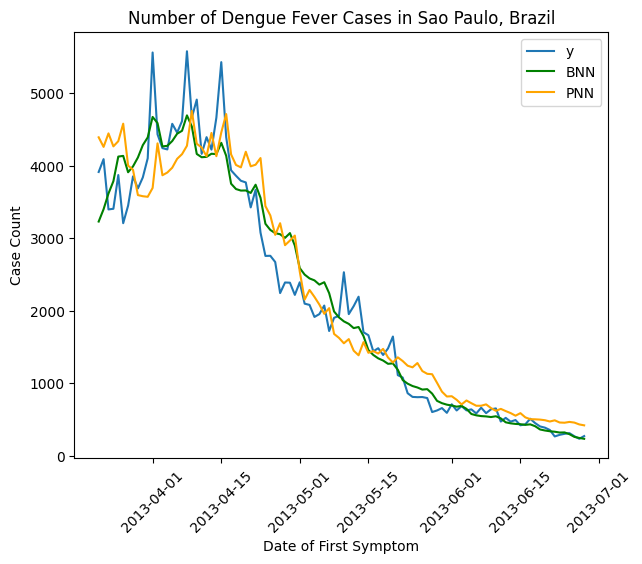

In [36]:
lam_post_samples = az.extract(idata, group='posterior', num_samples=1000)['lam']
lam_med = np.percentile(lam_post_samples, 50, axis=1)
lam_lower = np.percentile(lam_post_samples, 2.5, axis=1)
lam_upper = np.percentile(lam_post_samples, 97.5, axis=1)


y_plot = y_true[model_D:model_D + len_train]
y_plot.index = pd.to_datetime(y_plot.index)


plt.plot(y_plot.index, y_plot, label='y')

plt.plot(y_plot.index, lam_med, label='BNN', color='green')
# plt.fill_between(y_plot.index, lam_lower, lam_upper, color='green', alpha=0.2, label='BNN 95% CI')



plt.plot(y_plot.index, PNN_preds, label='PNN', color='orange')
# plt.fill_between(y_plot.index, PNN_lower, PNN_upper, color='orange', alpha=0.2, label='PNN 95% CI')


plt.legend()
plt.tight_layout()
plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.xticks(rotation=45)
plt.show()